In [ ]:
XGboost - hyper parameter tuning 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore, ks_2samp
import seaborn as sns
#!pip install xgboost
import xgboost as xgb

%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load the CSV file into a DataFrame
df = pd.read_csv(r'C:\Users\מיכאל\Desktop\air bnb germany project\df_level4_feature_selection.csv', encoding='latin1',low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169001 entries, 0 to 169000
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Unnamed: 0              169001 non-null  int64  
 1   Host Response Time      169001 non-null  float64
 2   Is Superhost            169001 non-null  float64
 3   neighbourhood           169001 non-null  float64
 4   Postal Code             169001 non-null  float64
 5   Is Exact Location       169001 non-null  float64
 6   Property Type           169001 non-null  float64
 7   Accomodates             169001 non-null  float64
 8   Beds                    169001 non-null  float64
 9   Guests Included         169001 non-null  float64
 10  Min Nights              169001 non-null  float64
 11  Reviews                 169001 non-null  float64
 12  Overall Rating          169001 non-null  float64
 13  Cleanliness Rating      169001 non-null  float64
 14  Location Rating     

In [3]:
df['Price'].describe()

count    169001.000000
mean        235.837847
std        7860.316083
min           0.000000
25%          35.000000
50%          51.000000
75%          80.000000
max      900000.000000
Name: Price, dtype: float64

In [4]:
df = df[df['Price'] > 0]

In [5]:
X = df.loc[:,df.columns != 'Price']
y = df['Price']

In [6]:
import os
import numpy as np
import pandas as pd
from joblib import parallel_backend
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Ensure all paths are ASCII-only
os.environ['JOBLIB_TEMP_FOLDER'] = '/path/to/ascii/directory'

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Expanded parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
}

# Initialize the model
mod = xgb.XGBRegressor()

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=mod,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_squared_error'  # This is for internal scoring in GridSearchCV
)

# Use parallel_backend explicitly
with parallel_backend('loky'):
    grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Negate the score to get positive MSE

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate additional metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Create a DataFrame to store the results
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R² Score'],
    'Value': [mse, rmse, mae, r2]
})

# Print the results
print("Best Parameters:", best_params)
print("Best Score (MSE) from GridSearchCV:", best_score)
print("\nMetrics on Test Set:")
(metrics_df)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best Score (MSE) from GridSearchCV: 29280819.410068527

Metrics on Test Set:


,Metric,Value
0,MSE,7.290329e+06
1,RMSE,2.700061e+03
2,MAE,1.908411e+02
3,R² Score,8.200500e-01


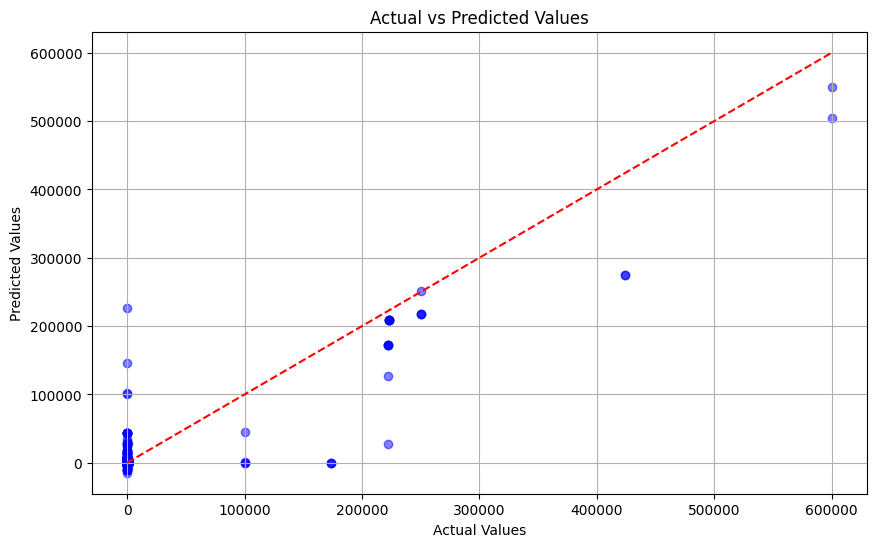

In [7]:
# Predict on the test set
y_pred = best_model.predict(X_test)

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='b')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.show()


In [8]:

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import parallel_backend

# Define price threshold
price_threshold = df['Price'].quantile(0.90)

# Split the data into low price and high price categories
df_low_price = df[df['Price'] <= price_threshold]
df_high_price = df[df['Price'] > price_threshold]

# Define features (X) and target (y) for each category
X_low = df_low_price.drop('Price', axis=1)
y_low = df_low_price['Price']
X_high = df_high_price.drop('Price', axis=1)
y_high = df_high_price['Price']

# Split the data into training and testing sets
X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(X_low, y_low, test_size=0.3, random_state=42)
X_train_high, X_test_high, y_train_high, y_test_high = train_test_split(X_high, y_high, test_size=0.3, random_state=42)

# Reduced parameter grid for faster search
param_distributions = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
}

# Initialize the model
mod = xgb.XGBRegressor()

# Setup RandomizedSearchCV for low price category
random_search_low = RandomizedSearchCV(
    estimator=mod,
    param_distributions=param_distributions,
    n_iter=10,
    cv=2,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_squared_error',
    random_state=42
)

# Use parallel_backend explicitly
with parallel_backend('loky'):
    random_search_low.fit(X_train_low, y_train_low)

# Best parameters and score for low price category
best_params_low = random_search_low.best_params_
best_score_low = -random_search_low.best_score_

# Evaluate the best model on the test set for low price category
best_model_low = random_search_low.best_estimator_
y_pred_low = best_model_low.predict(X_test_low)

# Metrics for low price category
mse_low = mean_squared_error(y_test_low, y_pred_low)
rmse_low = np.sqrt(mse_low)
mae_low = mean_absolute_error(y_test_low, y_pred_low)
r2_low = r2_score(y_test_low, y_pred_low)

# Setup RandomizedSearchCV for high price category
random_search_high = RandomizedSearchCV(
    estimator=mod,
    param_distributions=param_distributions,
    n_iter=10,
    cv=2,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_squared_error',
    random_state=42
)

# Use parallel_backend explicitly
with parallel_backend('loky'):
    random_search_high.fit(X_train_high, y_train_high)

# Best parameters and score for high price category
best_params_high = random_search_high.best_params_
best_score_high = -random_search_high.best_score_

# Evaluate the best model on the test set for high price category
best_model_high = random_search_high.best_estimator_
y_pred_high = best_model_high.predict(X_test_high)

# Metrics for high price category
mse_high = mean_squared_error(y_test_high, y_pred_high)
rmse_high = np.sqrt(mse_high)
mae_high = mean_absolute_error(y_test_high, y_pred_high)
r2_high = r2_score(y_test_high, y_pred_high)

# Create DataFrames to store results
results_df = pd.DataFrame({
    'Category': ['Low Price', 'High Price'],
    'Best Parameters': [best_params_low, best_params_high],
    'MSE': [mse_low, mse_high],
    'RMSE': [rmse_low, rmse_high],
    'MAE': [mae_low, mae_high],
    'R² Score': [r2_low, r2_high]
})

# Print the results DataFrame
(results_df)


Fitting 2 folds for each of 8 candidates, totalling 16 fits
Fitting 2 folds for each of 8 candidates, totalling 16 fits


,Category,Best Parameters,MSE,RMSE,MAE,R² Score
0,Low Price,"{'n_estimators': 200, 'max_depth': 6, 'learnin...",1.682079e+02,12.969499,9.404853,0.726154
1,High Price,"{'n_estimators': 200, 'max_depth': 6, 'learnin...",3.020705e+08,17380.175744,1235.542259,0.577589


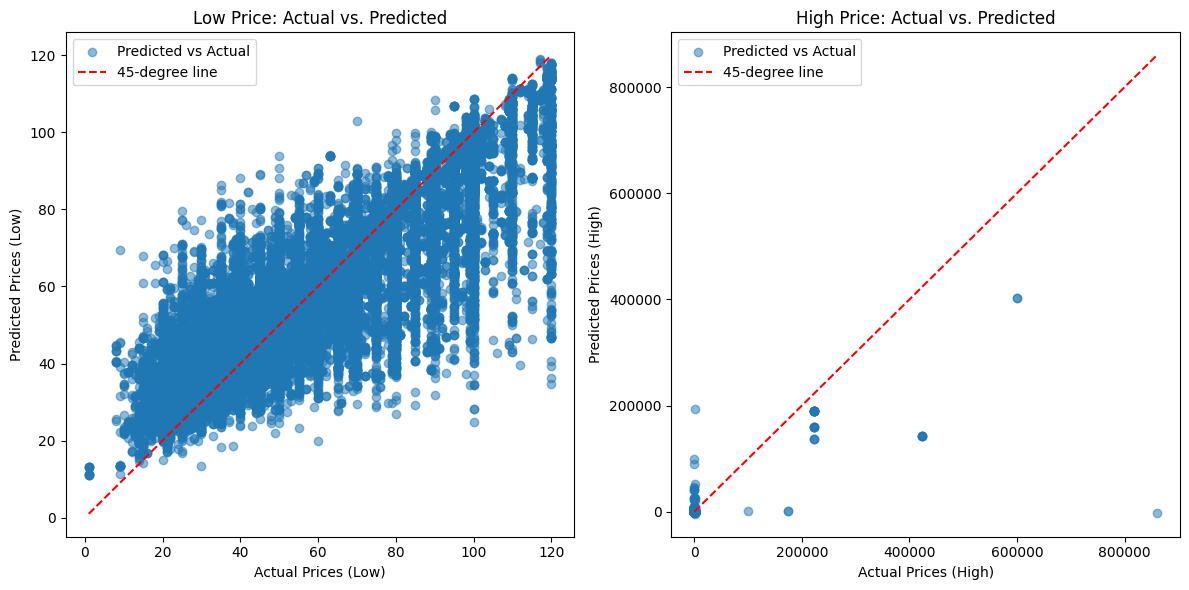

In [9]:
# Plotting actual vs predicted values for low price category
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test_low, y_pred_low, alpha=0.5, label='Predicted vs Actual')
plt.plot([y_test_low.min(), y_test_low.max()], [y_test_low.min(), y_test_low.max()], 'r--', label='45-degree line')
plt.xlabel('Actual Prices (Low)')
plt.ylabel('Predicted Prices (Low)')
plt.title('Low Price: Actual vs. Predicted')
plt.legend()

# Plotting actual vs predicted values for high price category
plt.subplot(1, 2, 2)
plt.scatter(y_test_high, y_pred_high, alpha=0.5, label='Predicted vs Actual')
plt.plot([y_test_high.min(), y_test_high.max()], [y_test_high.min(), y_test_high.max()], 'r--', label='45-degree line')
plt.xlabel('Actual Prices (High)')
plt.ylabel('Predicted Prices (High)')
plt.title('High Price: Actual vs. Predicted')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
#The findings suggest that smaller price values, which have more consistent and reliable data, 
#are predicted with higher accuracy compared to larger price values, where the model's
#predictions are less reliable and more variable.